In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [10]:
train_data1 = np.load('data0.npy')
lab_data = np.load('lab0.npy')

In [11]:
class SumOfDigitsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # image shape: (H, W) in numpy
        img = self.images[idx].astype(np.float32)  # convert to float32
        lbl = int(self.labels[idx])

        # add channel dimension: (1, H, W)
        img = np.expand_dims(img, axis=0)  # from (H, W) -> (1, H, W)

        # If you want to normalize (0..1):
        img /= 255.0

        # Convert to torch tensors
        img_tensor = torch.from_numpy(img)    # shape: (1, H, W)
        lbl_tensor = torch.tensor(lbl, dtype=torch.long)

        # Optional transform
        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, lbl_tensor





In [12]:
dataset = SumOfDigitsDataset(train_data1, lab_data)

In [14]:
train_indices, val_indices = train_test_split(
    np.arange(len(dataset)), test_size=0.2, random_state=42
)


In [15]:
train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset   = torch.utils.data.Subset(dataset, val_indices)

In [8]:
num_classes = 37

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # After two poolings, if input is HxW,
        # output will be (H/4)x(W/4) in spatial dimension.
        # Let’s figure out the dimension for the linear layer:
        # But to keep it simple, we’ll do this dynamically in forward() with a flatten.

        self.fc1 = nn.Linear(64 *  ( (dataset[0][0].shape[1]//4 ) * (dataset[0][0].shape[2]//4 )), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (B, 1, H, W)
        x = self.conv1(x)       # (B, 32, H, W)
        x = nn.functional.relu(x)
        x = self.pool1(x)       # (B, 32, H/2, W/2)

        x = self.conv2(x)       # (B, 64, H/2, W/2)
        x = nn.functional.relu(x)
        x = self.pool2(x)       # (B, 64, H/4, W/4)

        # Flatten
        x = x.view(x.size(0), -1)  # (B, 64*(H/4)*(W/4))

        x = self.fc1(x)         # (B, 128)
        x = nn.functional.relu(x)
        x = self.fc2(x)         # (B, num_classes)

        return x

model = SimpleCNN(num_classes=num_classes)
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=26880, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=37, bias=True)
)


In [17]:
model = torch.load('baseline_model.pth')

In [20]:
model.eval()
with torch.no_grad():
    img = img.unsqueeze(0)
    output = model(img)
    pred_sum = torch.argmax(output, dim=1).item()

print("Predicted sum:", pred_sum)

Predicted sum: 17


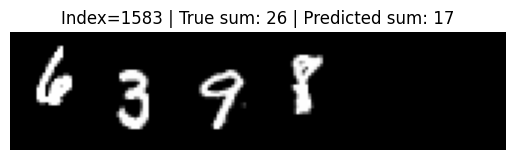

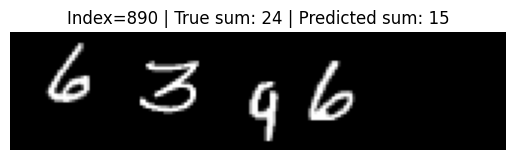

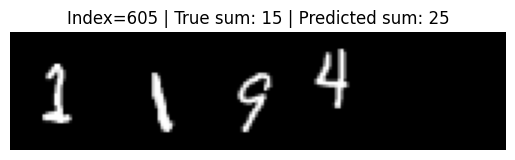

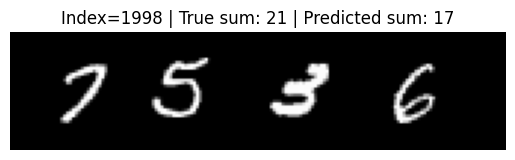

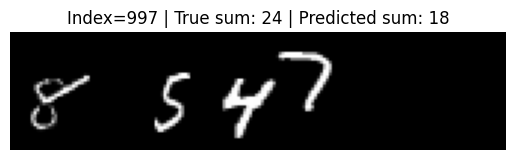

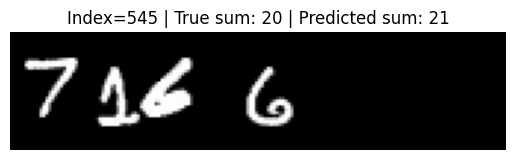

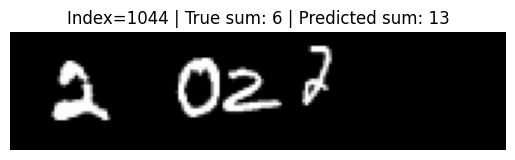

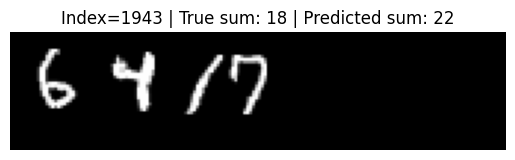

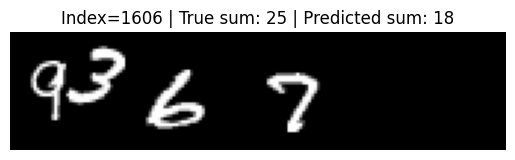

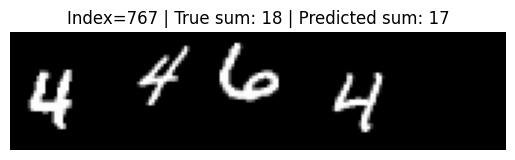

In [21]:
import random
import matplotlib.pyplot as plt

# We'll pick 10 random indices from the validation set.
# If you don't have a Subset, but just arrays, adapt accordingly.
indices_to_check = random.sample(range(len(val_subset)), 10)

model.eval()

for idx in indices_to_check:
    # Retrieve one sample from val_subset: (img, label)
    img, true_sum = val_subset[idx]
    
    # 'img' might be shape (1, H, W) if your dataset already added the channel dimension
    # or (H, W) if not. Adjust accordingly.
    
    # If needed, expand dimensions for batch
    # (Remove .unsqueeze(0) if your dataset is already returning shape [C, H, W] 
    #  and you only need one unsqueeze for batch. Example below for a typical shape (1, H, W).)
    img_batch = img.unsqueeze(0)  # shape: (1, 1, H, W)
    
    # Forward pass (no gradient)
    with torch.no_grad():
        output = model(img_batch)
        pred_sum = torch.argmax(output, dim=1).item()

    # Plot the image
    # If 'img' has shape (1, H, W), we can do img[0] to get (H, W).
    plt.imshow(img[0].cpu().numpy(), cmap='gray') 
    plt.title(f"Index={idx} | True sum: {true_sum} | Predicted sum: {pred_sum}")
    plt.axis("off")
    plt.show()
